## 2.4.4. Make your own regression model

<em>From previous assignment.. </em>
<blockquote>Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:
    
$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$
</blockquote>

Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

In [38]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import math

In [39]:
path = ("/Users/gemma/Documents/data science/DS bootcamp/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv"
            )
df = pd.read_csv(path, delimiter= ',', encoding='latin-1',header=0)


In [40]:
# getting names of columns to access them more easily
# and renaming murder because the name is messy

colnames = df.columns.values
print(colnames)

# renamed it originally but later on wasn't necessary bc i dropped the columns
#df.rename({'Murder and\nnonnegligent\nmanslaughter' : 'Murder etc'}, axis='columns', inplace=True)


['City' 'Population' 'Violent\ncrime'
 'Murder and\nnonnegligent\nmanslaughter' 'Rape\n(revised\ndefinition)1'
 'Rape\n(legacy\ndefinition)2' 'Robbery' 'Aggravated\nassault'
 'Property\ncrime' 'Burglary' 'Larceny-\ntheft' 'Motor\nvehicle\ntheft'
 'Arson3']


In [41]:
df.head(3)


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0


In [42]:
# adding binary features - murder (or robbery) > 0 = 1, else 0

df['Murder bin'] = np.where(df[colnames[3]]==0, 0, 1)
df['Robbery bin'] = np.where(df['Robbery'] == 0, 0, 1)

In [43]:
df.head(3)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Murder bin,Robbery bin
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0,0,1
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0,0,1
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0,0,1


In [44]:
# making the data frame i'll use for the regression

crime = df.drop(labels=colnames[2:8], axis=1)
crime.drop(labels=colnames[9:13], axis=1, inplace=True)

In [45]:
# renaming the weirdly named columns

crime.rename({'Murder bin': 'Murder', 'Robbery bin':'Robbery', 
              'Property\ncrime': 'Property crime'}, axis='columns',inplace=True)


In [46]:
# cleaning up population and property crime 

num_cleanup = ['Population', 'Property crime'] 

# there's at least one cell (in Population) with just a space, so filling blanks with NaN
crime = crime.replace(r'^\s*$', np.nan, regex=True)

# now dropping the row(s) that contain(s) the nan 
crime.dropna(axis=0, how='any', inplace=True)

# dropping commas and making integers

def cleanup(data_fr, numeric_str):
    # getting rid of commas
    data_fr[numeric_str] = data_fr[numeric_str].apply(lambda x: ''.join(list(filter(str.isdigit, str(x)))))

    # finally! the series is an integer (checked in the cell below)
    data_fr[numeric_str] = data_fr[numeric_str].astype(int)
    
    return

for one in num_cleanup:
    cleanup(crime, one)

# double checking
crime.dtypes


City              object
Population         int64
Property crime     int64
Murder             int64
Robbery            int64
dtype: object

In [47]:
crime.head(3)

,City,Population,Property crime,Murder,Robbery
0,Adams Village,1861,12,0,1
1,Addison Town and Village,2577,24,0,1
2,Akron Village,2846,16,0,1


In [48]:
# adding pop ^2 bc i didnt do that yet

crime.insert(2, 'Popˆ2', crime['Population']**2, allow_duplicates=False)

In [49]:
crime.head(3)

,City,Population,Popˆ2,Property crime,Murder,Robbery
0,Adams Village,1861,3463321,12,0,1
1,Addison Town and Village,2577,6640929,24,0,1
2,Akron Village,2846,8099716,16,0,1


In [111]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime['Property crime'].values.reshape(-1, 1)
X = crime[['Population','Popˆ2','Murder','Robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  1.44802892e-02   1.08747761e-07   2.06933253e+02   0.00000000e+00]]

Intercept: 
 [ 18.86199165]

R-squared:
0.843013263732


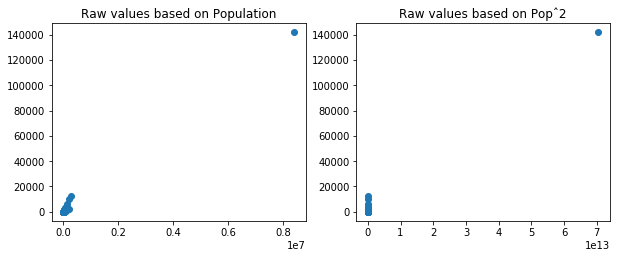

In [51]:
# checking if the data fits the assumtion of being linear...

labels = ['Population', 'Popˆ2']

#,'Murder','Robbery']  #theyre binary so this is silly

plt.figure(figsize=(10,8))

for i, label in enumerate(labels):

    plt.subplot(2,2,i+1)
    plt.scatter(crime[label], Y)
    plt.title('Raw values based on {}'.format(label))

plt.show()

In [52]:
# looks like there's an outlier skewing the results

max(crime['Property crime'].unique().tolist())

141971

In [53]:
# finding where the outlier is

crime[crime['Property crime'] == 141971]

,City,Population,Popˆ2,Property crime,Murder,Robbery
216,New York,8396126,70494931807876,141971,1,1


In [54]:
# dropping it

crime.drop([216], inplace=True)

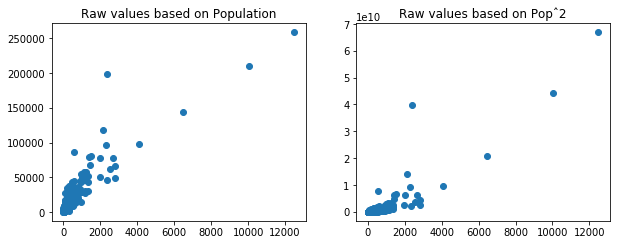

In [55]:
# to check again for linearity of data

plt.figure(figsize=(10,8))

for i, label in enumerate(labels):

    plt.subplot(2,2,i+1)
    plt.scatter(crime['Property crime'].values.reshape(-1, 1), crime[label])
    plt.title('Raw values based on {}'.format(label))

plt.show()

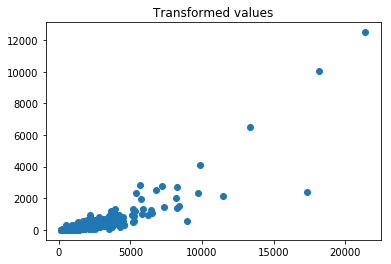

In [56]:
def myformula(value):
    return value**.4

crime['popˆ2 ftd'] = crime['Popˆ2'].apply(myformula)

plt.scatter(crime['popˆ2 ftd'],  crime['Property crime'].values.reshape(-1, 1))
plt.title('Transformed values')
plt.show()

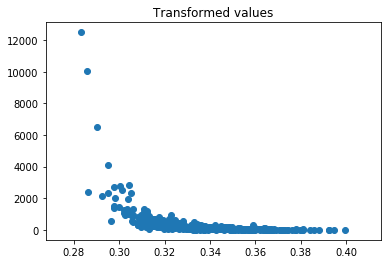

In [99]:
def my2ndform(value):
    return 1/math.sqrt(math.log(value))
#    return math.sqrt(value**3)
    

crime['log pop ftd'] = crime['Population'].apply(my2ndform)

plt.scatter(crime['log pop ftd'],  crime['Property crime'].values.reshape(-1, 1))
plt.title('Transformed values')
plt.show()

In [57]:
crime.head(4)

,City,Population,Popˆ2,Property crime,Murder,Robbery,popˆ2 ftd
0,Adams Village,1861,3463321,12,0,1,412.854572
1,Addison Town and Village,2577,6640929,24,0,1,535.662859
2,Akron Village,2846,8099716,16,0,1,579.946480
3,Albany,97956,9595377936,4090,1,1,9836.143001


In [58]:
# trying to figure out the error below
print(len(crime[['Population','popˆ2 ftd']]))

actual = crime['Property crime']

print(len(actual))

347
347


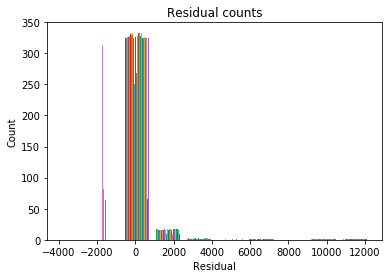

In [116]:
X2 = crime[['Population', 'Murder', 'Robbery', 'log pop ftd']]

# Extract predicted values.
predicted = regr.predict(X2).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

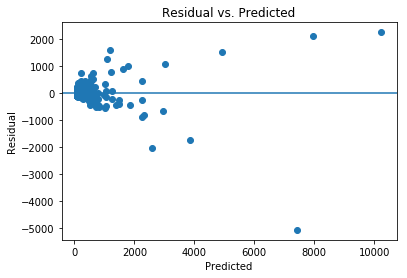

In [73]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


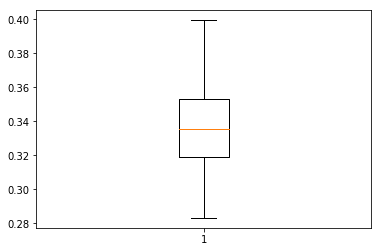

In [101]:
plt.boxplot(crime['log pop ftd'])
plt.show()

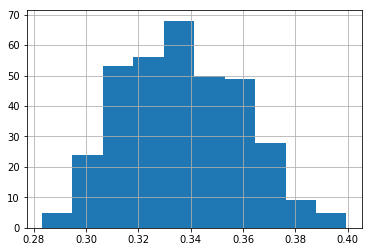

In [100]:
crime['log pop ftd'].hist()

In [117]:
regr = linear_model.LinearRegression()
Y3 = crime['Property crime'].values.reshape(-1, 1)
X3 = crime[['log pop ftd','Popˆ2','Murder','Robbery']]
regr.fit(X3, Y3)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X3, Y3))


Coefficients: 
 [[ -6.98569406e+03   1.64365212e-07   2.89047078e+02   0.00000000e+00]]

Intercept: 
 [ 2536.13671252]

R-squared:
0.836138056906


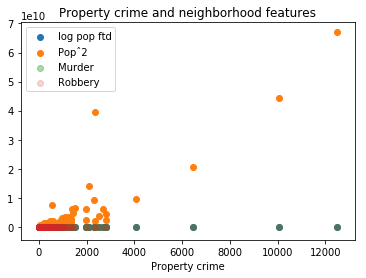

In [131]:
plt.scatter(crime['Property crime'], crime['log pop ftd'])
plt.scatter(crime['Property crime'], crime['Popˆ2'])
plt.scatter(crime['Property crime'], crime['Murder'], alpha=0.4)
plt.scatter(crime['Property crime'], crime['Robbery'], alpha=0.2)
plt.legend()
plt.xlabel('Property crime')
plt.title('Property crime and neighborhood features')
plt.show()


In [136]:
correlation_matrix = X3.corr()
display(correlation_matrix)


,log pop ftd,Popˆ2,Murder,Robbery
log pop ftd,1.000000,-0.362512,-0.456437,NaN
Popˆ2,-0.362512,1.000000,0.344873,NaN
Murder,-0.456437,0.344873,1.000000,NaN
Robbery,NaN,NaN,NaN,NaN


###  The feature engineering and selection process

Inititally I used the features from the previous assignment - population, population squared, murder (a binary/ categorical indicator) and robbery (another binary/ categorical indictaor) and used that information in my first attempt at a linear regression model.

The first model's R value was 84, and the y intercept was 18, which means that the model predicts accurately in about 84% of cases, and there is an assumption of about 18 property crimes at a minimum. 

In an effort to increase the accuracy of the model, I tried to make sure all of the variables/ features had linear relationships with the amount of property crime by transforming variables where necessary, fix each feature for normality, use categorical features to account for heteroscedasticity, and removed the most extreme outlier of proprety crime, which was skewing the data.

After cleaning the data, transforming the features to fit the above described assumptions of linear regression, and re-attempting the linear regression model, the R value was 83.6, and the y-intercept was 2536. Because the R value actually decreased slightly, it appears that the feature transformation didn't actually improve the linear regression model. Based on this, it appears like the initital linear regression model was more accurate and more useful in practice.